In [1]:
import pandas as pd
import numpy as np
import math
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
%matplotlib inline
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/justinchen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df = pd.read_csv('/Users/justinchen/Desktop/AARD Datasets/all_subreddits.csv')

In [3]:
df.tail()

,Unnamed: 0,subreddit.name,created_utc,body,sentiment
249995,16802881,unemployment,1586483390,Yeah I believe you are right.\n\nLook at the g...,0.8402
249996,9285909,askreddit,1609412233,"No offense taken, we all grew up under differe...",-0.5885
249997,10237762,iama,1606925404,"James here: Really good question. So, the answ...",-0.9417
249998,12742373,asktrumpsupporters,1599704873,Flip flopping on covid information. Not sure i...,0.3002
249999,6810474,formula1,1616861249,We need more covid,0.0000


In [4]:
df.dropna(axis = 0, how = 'any')

,Unnamed: 0,subreddit.name,created_utc,body,sentiment
0,7951721,oakisland,1613168164,Carmen Legge was at the Northville Farm ([http...,0.0000
1,13261673,ukpolitics,1597987216,You don't need to be an expert to see that Bor...,0.0000
2,261403,amazonfc,1634437900,Just made a month! lol and I’ve worked at amaz...,0.7818
3,15681814,drugs,1590316428,It looks like you're discussing that thing. Co...,0.8391
4,3153614,politics,1628274205,"&gt;“Decent covid response” yes, killing the s...",0.7289
...,...,...,...,...,...
249995,16802881,unemployment,1586483390,Yeah I believe you are right.\n\nLook at the g...,0.8402
249996,9285909,askreddit,1609412233,"No offense taken, we all grew up under differe...",-0.5885
249997,10237762,iama,1606925404,"James here: Really good question. So, the answ...",-0.9417
249998,12742373,asktrumpsupporters,1599704873,Flip flopping on covid information. Not sure i...,0.3002


## Preprocessing

In [5]:
import re
import demoji 
demoji.download_codes()

/var/folders/q6/mkn146812pz0n3cx40bgg__40000gn/T/ipykernel_667/79378484.py:3: FutureWarning: The demoji.download_codes attribute is deprecated and will be removed from demoji in a future version. It is an unused attribute as emoji codes are now distributed directly with the demoji package.
  demoji.download_codes()


In [6]:
def pre_cleaning(text):
    line = re.sub(r"\Bu/\w+", ' ', text) #remove usernames
    line = demoji.replace(line, repl=' ')
    return line

In [7]:
#removing stopwords and urls, stemming, making lowercase 
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

def cleaning(text, stem=False):
    text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stTem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [8]:
def post_cleaning(text):
    # Remove special characters
    feature = re.sub(r'\W', ' ',text)

    # remove single characters
    feature= re.sub(r'\s+[a-zA-Z]\s+', ' ', feature)

    # Remove single characters from the start
    feature = re.sub(r'\^[a-zA-Z]\s+', ' ', feature) 
    
    #remove digits
    feature = re.sub("^\d+\s|\s\d+\s|\s\d+$", " ", feature)

    # Substituting multiple spaces with single space
    feature = re.sub(r'\s+', ' ', feature, flags=re.I)

    return feature

In [9]:
#above functions combined
def preprocessing(text):
    line = cleaning(text)
    line = post_cleaning (line)
    return line

In [10]:
df.body = df.body.apply(lambda x: preprocessing(x))

In [11]:
df.head()

,Unnamed: 0,subreddit.name,created_utc,body,sentiment
0,7951721,oakisland,1613168164,carmen legge northville farm centerville nova ...,0.0000
1,13261673,ukpolitics,1597987216,need expert see boris covid brexit fall guy,0.0000
2,261403,amazonfc,1634437900,made month lol worked amazon covid hit whole f...,0.7818
3,15681814,drugs,1590316428,looks like discussing thing contact medical em...,0.8391
4,3153614,politics,1628274205,gt decent covid response yes killing states ec...,0.7289


In [12]:
sample = df.sample(20000)

In [13]:
for sentiment in sample['sentiment']:
    if sentiment >= 0:
        sample['sentiment'].replace({sentiment : 'positive'}, inplace=True)
    if sentiment < 0:
        sample['sentiment'].replace({sentiment : 'negative'}, inplace=True)
#     else:
#         sample['sentiment'].replace({sentiment : 'neutral'}, inplace=True)

In [14]:
sample.head()

,Unnamed: 0,subreddit.name,created_utc,body,sentiment
59570,154692,nyknicks,1634744900,concerned lakers egos think lot guys realize b...,positive
220779,15265663,nba,1591901993,gt exactly shut operations pretty much nothing...,positive
118104,4032234,sarmsourcetalk,1626200682,hi packages actually sitting india long see up...,positive
22446,11971090,dankmemes,1602078494,bing covid,NaN
194337,9691890,conspiracy,1608329060,scientists figure shit google airplanes safe c...,negative


Text(0.5, 1.0, 'Sentiment Data Distribution')

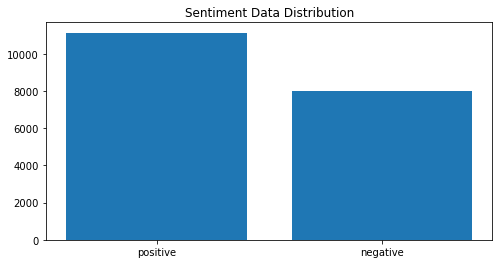

In [15]:
#Graphing
val_count = sample.sentiment.value_counts()
plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.title("Sentiment Data Distribution")

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
 # Splits Dataset into Training and Testing set
train_size = 0.8
train_data, test_data = train_test_split(sample, test_size=1-train_size, random_state=42, shuffle=True)
print("Train Data size:", len(train_data))
print("Test Data size", len(test_data))

Train Data size: 16000
Test Data size 4000


## Model

In [18]:
import tensorflow as tf
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Dropout
from sklearn.preprocessing import LabelEncoder

In [70]:
lb=LabelEncoder()
sample['sentiment'] = lb.fit_transform(sample['sentiment'])

In [71]:
tokenizer = Tokenizer(num_words=500, split=' ') 
tokenizer.fit_on_texts(sample['body'].values)
X = tokenizer.texts_to_sequences(sample['body'].values)
X = pad_sequences(X, maxlen = 300)

In [72]:
X.shape

(20000, 300)

In [73]:
y = sample['sentiment'].values
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42)

In [74]:
model = Sequential()
model.add(Embedding(X.shape[0], 64, input_length = X.shape[1]))
model.add(Dropout(0.2))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss = 'BinaryCrossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate = 0.01), metrics = ['accuracy'])
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 300, 64)           1280000   
                                                                 
 dropout_4 (Dropout)         (None, 300, 64)           0         
                                                                 
 lstm_4 (LSTM)               (None, 128)               98816     
                                                                 
 dense_4 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,378,945
Trainable params: 1,378,945
Non-trainable params: 0
_________________________________________________________________
None


In [75]:
batch_size=128
model.fit(X_train, y_train, epochs = 5, batch_size=batch_size, verbose = 'auto')

Epoch 1/5
125/125 [==============================] - 123s 974ms/step - loss: 0.1898 - accuracy: 0.6083
Epoch 2/5
125/125 [==============================] - 144s 1s/step - loss: -2.1697 - accuracy: 0.6441
Epoch 3/5
125/125 [==============================] - 158s 1s/step - loss: -5.1944 - accuracy: 0.6566
Epoch 4/5
125/125 [==============================] - 146s 1s/step - loss: -9.0067 - accuracy: 0.6544
Epoch 5/5
125/125 [==============================] - 145s 1s/step - loss: -12.8037 - accuracy: 0.6532


In [76]:
model.evaluate(X_test,y_test)

125/125 [==============================] - 10s 74ms/step - loss: -10.8514 - accuracy: 0.5940


[-10.851407051086426, 0.593999981880188]

## Plot Sentiment Over Time

In [ ]:
plt.figure(1,figsize=(30,8))

plt.subplot(131)
 #Code for fig1.
plt.subplot(132)
#code for fig2
plt.subplot(133)
#code for fig3.
plt.show()

### Anxiety

In [149]:
anxiety_prepandemic = pd.read_csv('/Users/justinchen/Desktop/AARD Datasets/anxiety_pre_features_tfidf_256.csv')
anxiety_midpandemic = pd.read_csv('/Users/justinchen/Desktop/AARD Datasets/anxiety_post_features_tfidf_256.csv')
anxiety = pd.concat([anxiety_midpandemic, anxiety_prepandemic])
anxiety.sort_values('date', inplace = True)
anxiety

,subreddit,author,date,post,automated_readability_index,coleman_liau_index,flesch_kincaid_grade_level,flesch_reading_ease,gulpease_index,gunning_fog_index,...,tfidf_wish,tfidf_without,tfidf_wonder,tfidf_work,tfidf_worri,tfidf_wors,tfidf_would,tfidf_wrong,tfidf_x200b,tfidf_year
0,anxiety,Sweet0ptimisms,2020/01/01,Anybody else feel like they're sick more often...,6.284254,8.554787,5.186842,80.436228,67.289474,7.171930,...,0.0,0.0,0.249723,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,anxiety,calmthemind7,2020/01/01,Has anyone else had bad anxiety for a week str...,3.688421,5.845312,4.382316,83.948211,74.087719,8.068772,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,anxiety,Munous,2020/01/01,"Honestly, I don’t know. I feel like I need to ...",6.045035,6.830876,6.387234,77.173333,66.446809,9.841135,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,anxiety,montanugh,2020/01/01,I’m terrified and I don’t know why I go back t...,-2.240446,-0.504975,1.303309,99.585711,95.055046,4.215203,...,0.0,0.0,0.000000,0.134660,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,anxiety,skaterkid24,2020/01/01,New Years Anxiety? So my anxiety came roaring ...,4.679941,5.021470,5.746132,82.140773,69.314961,9.499606,...,0.0,0.0,0.000000,0.000000,0.000000,0.166694,0.000000,0.000000,0.198759,0.210671
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19971,anxiety,heretothrowawaynow,2019/08/11,Ugh I didn't check my class GC for 3 days beca...,0.793333,1.986409,2.856667,95.955000,79.555556,5.911111,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
19972,anxiety,throwawayreddit67778,2019/08/11,Anybody else get bad anxiety the day after eat...,4.184799,5.402657,5.798976,78.125492,70.987952,9.388755,...,0.0,0.0,0.125248,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
19973,anxiety,throwaway52689533564,2019/08/11,My brain is cruel Looking for some advice. I'...,1.801679,4.017217,3.496186,87.716433,80.391753,6.453714,...,0.0,0.0,0.000000,0.270118,0.000000,0.000000,0.131786,0.101417,0.000000,0.000000
19974,anxiety,krisappear,2019/08/11,I change how I live to avoid potentially upset...,5.703326,7.040841,5.407554,81.896549,67.521739,8.184783,...,0.0,0.0,0.000000,0.000000,0.178041,0.000000,0.249078,0.000000,0.000000,0.000000


In [150]:
for index in range(170):
    if index > 4 :
        anxiety.drop(anxiety.columns[index], axis = 1, inplace = True)

In [151]:
anxiety.post = anxiety.post.apply(lambda x: preprocessing(x))

In [152]:
tokenizer = Tokenizer(num_words=500, split=' ') 
tokenizer.fit_on_texts(anxiety['post'].values)
anxiety_vec = tokenizer.texts_to_sequences(anxiety['post'].values)
anxiety_vec = pad_sequences(anxiety_vec, maxlen = 300)

In [153]:
sentiment = model(anxiety_vec)

In [154]:
anxiety.insert(4, "sentiment", sentiment)

In [155]:
list_sent = list(anxiety['sentiment'].values)

In [216]:
anxiety = anxiety.reset_index()
anxiety

,index,subreddit,author,date,post,average_sentiment,sentiment,automated_readability_index,flesch_kincaid_grade_level,gulpease_index,...,tfidf_wish,tfidf_without,tfidf_wonder,tfidf_work,tfidf_worri,tfidf_wors,tfidf_would,tfidf_wrong,tfidf_x200b,tfidf_year
0,18817,anxiety,babyrosegirl76,2018/11/02,finally registering something unavoidable givi...,0.434829,0.587422,8.019530,8.137982,62.846154,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
1,18744,anxiety,Alexanderismyname,2018/11/02,today rough day feel like going explode want p...,0.685035,0.665348,4.468000,5.252500,69.750000,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
2,18745,anxiety,RocketCsiensei,2018/11/02,figured funny way primal scream therapy hello ...,0.698266,0.902193,3.142812,3.707687,75.938776,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
3,18746,anxiety,nonamenopassword,2018/11/02,med med know really personal question decision...,0.754643,0.649005,4.170870,5.429459,71.186495,...,0.0,0.0,0.105577,0.000000,0.098868,0.0,0.069158,0.000000,0.000000,0.062693
4,18747,anxiety,pastaaldente,2018/11/02,feeling guilty saying social activities curren...,0.615784,0.897099,5.098590,5.396628,68.810127,...,0.0,0.0,0.000000,0.108931,0.000000,0.0,0.000000,0.163594,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35867,15802,anxiety,skywheel93,2020/04/20,eat losing weight anxiety situation world righ...,0.678838,0.642538,3.017282,4.122146,77.155340,...,0.0,0.0,0.000000,0.155751,0.000000,0.0,0.151977,0.000000,0.000000,0.000000
35868,15801,anxiety,mjanks,2020/04/20,anyone tried shift breathing necklace post mon...,0.678841,1.000000,3.201000,2.675000,84.666667,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
35869,15800,anxiety,golden_1337,2020/04/20,gained kg due mental health issues need help s...,0.678827,0.417683,2.818692,4.463374,76.912773,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.097753,0.362640
35870,15798,anxiety,awsome1014,2020/04/20,scared getting fillings may autism special nee...,0.678833,0.660868,2.742913,3.434767,77.737864,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000


In [274]:
def Average(lst):
    if len(lst) == 0:
        return 0
    else:
        return sum(lst) / len(lst)
    

In [334]:
def avg_over_time(df, df_length):
    avg_sentiment_dict = {}
    for year in ['2018', '2019', '2020']:
        for month in ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']:
            for day in ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32']:
                index_list = []
                sentiment_list = []
                for a in range(df_length):
                    date = df.at[a, 'date']
                    date = re.sub(r'/', ' ', date)
                    date = date.split()
                    if date[0] == year and date[1] == month and date[2] == day:
                        index_list.append(a)
                average = 0
                for index in index_list:
                    sentiment = df.at[index, 'sentiment']
                    sentiment_list.append(sentiment)
                average = Average(sentiment_list)
                avg_sentiment_dict[(year, month, day)] = average
    key_list = []
    for key, value in avg_sentiment_dict.items():
        if value == 0:
            key_list.append(key)
    for key in key_list:
        del avg_sentiment_dict[key]
    return avg_sentiment_dict

In [315]:
anxiety_dict = avg_over_time(anxiety, 35872)
anxiety_dict

### Depression

In [332]:
depression_prepandemic = pd.read_csv('/Users/justinchen/Desktop/AARD Datasets/depression_pre.csv')
depression_midpandemic = pd.read_csv('/Users/justinchen/Desktop/AARD Datasets/depression_post.csv')
depression = pd.concat([depression_midpandemic, depression_prepandemic])
depression.sort_values('date', inplace = True)
depression = depression.reset_index()
depression

,index,subreddit,author,date,post,automated_readability_index,coleman_liau_index,flesch_kincaid_grade_level,flesch_reading_ease,gulpease_index,...,tfidf_wish,tfidf_without,tfidf_wonder,tfidf_work,tfidf_worri,tfidf_wors,tfidf_would,tfidf_wrong,tfidf_x200b,tfidf_year
0,17576,depression,GoldenRetLovr,2018/11/04,Wife is struggling and i’m so scared to lose h...,2.238649,4.152562,3.267529,91.406338,77.558559,...,0.0,0.000000,0.0,0.057208,0.079804,0.080082,0.055822,0.000000,0.0,0.101208
1,17371,depression,viridusleo,2018/11/04,My first 2 hours on Zoloft I’m going through t...,4.322461,5.770419,4.908132,83.761533,70.929825,...,0.0,0.089900,0.0,0.000000,0.000000,0.000000,0.000000,0.101965,0.0,0.000000
2,17372,depression,tundradesert122,2018/11/04,All of my friends are depressed and it's hurti...,4.903562,5.933712,5.621808,80.761205,69.136986,...,0.0,0.000000,0.0,0.000000,0.251585,0.000000,0.000000,0.000000,0.0,0.000000
3,17373,depression,wow_anotherthrow,2018/11/04,i want to just run away and start over ive fel...,1.361500,3.018931,3.106571,92.738429,79.285714,...,0.0,0.000000,0.0,0.134761,0.000000,0.000000,0.000000,0.000000,0.0,0.178806
4,17374,depression,haloshornsglitter,2018/11/04,Depression &amp; Relationships I've been depre...,1.350250,3.436906,3.158333,90.230000,81.250000,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59237,37875,depression,itmenikorin,2020/04/20,Covid-19 Sad boi hours Idk if this is the righ...,2.702618,4.742724,4.105922,85.344597,76.612903,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
59238,37876,depression,iwannaschleep,2020/04/20,"I do not see a point anymore I'm in college, a...",4.951977,5.217124,6.086172,80.206724,68.706840,...,0.0,0.100817,0.0,0.152279,0.000000,0.000000,0.148589,0.000000,0.0,0.067350
59239,37877,depression,ookami738,2020/04/20,I have an issue with motivational speakers and...,6.219531,6.879994,6.383333,77.795000,66.031250,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.144562,0.0,0.085145
59240,37879,depression,helppleaseimhurting,2020/04/20,I feel like I have been getting better Sleepin...,5.444799,6.462925,6.218315,77.018883,67.892617,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.069299,0.000000,0.0,0.062822


In [338]:
depression.post = depression.post.apply(lambda x: preprocessing(x))

In [339]:
tokenizer = Tokenizer(num_words=500, split=' ') 
tokenizer.fit_on_texts(depression['post'].values)
depression_vec = tokenizer.texts_to_sequences(depression['post'].values)
depression_vec = pad_sequences(depression_vec, maxlen = 300)

In [340]:
sentiment = model(depression_vec)
depression.insert(4, "sentiment", sentiment)

In [341]:
depression_dict = avg_over_time(depression, 59242)
depression_dict

{('2018', '11', '04'): 0.6647763242753016,
 ('2018', '11', '07'): 0.684872777339374,
 ('2018', '11', '20'): 0.6688749635152252,
 ('2018', '11', '26'): 0.6720957665059429,
 ('2018', '11', '28'): 0.6485171566270802,
 ('2018', '11', '29'): 0.6973206121727007,
 ('2018', '12', '02'): 0.6830914548618414,
 ('2018', '12', '12'): 0.6651254818683399,
 ('2019', '01', '07'): 0.6623520688210647,
 ('2019', '01', '08'): 0.6613101554595358,
 ('2019', '02', '06'): 0.6699331249761326,
 ('2019', '02', '11'): 0.6707866895513077,
 ('2019', '03', '02'): 0.6592730782174965,
 ('2019', '03', '08'): 0.6649804728824907,
 ('2019', '03', '10'): 0.6737014188840795,
 ('2019', '03', '13'): 0.654407209803714,
 ('2019', '03', '19'): 0.6890475219223846,
 ('2019', '04', '02'): 0.6820400233105831,
 ('2019', '04', '07'): 0.6776133497818048,
 ('2019', '04', '08'): 0.675671864045729,
 ('2019', '04', '12'): 0.6769440908480829,
 ('2019', '04', '21'): 0.6851003740102369,
 ('2019', '04', '22'): 0.6636258875121884,
 ('2019', '04'

### MentalHealth

In [347]:
mentalhealth_prepandemic = pd.read_csv('/Users/justinchen/Desktop/AARD Datasets/mentalhealth_pre.csv')
mentalhealth_midpandemic = pd.read_csv('/Users/justinchen/Desktop/AARD Datasets/mentalhealth_post.csv')
mentalhealth = pd.concat([mentalhealth_midpandemic, mentalhealth_prepandemic])
mentalhealth.sort_values('date', inplace = True)
mentalhealth = mentalhealth.reset_index()
mentalhealth

,index,subreddit,author,date,post,automated_readability_index,coleman_liau_index,flesch_kincaid_grade_level,flesch_reading_ease,gulpease_index,...,tfidf_wish,tfidf_without,tfidf_wonder,tfidf_work,tfidf_worri,tfidf_wors,tfidf_would,tfidf_wrong,tfidf_x200b,tfidf_year
0,15193,mentalhealth,andrewdixon2,2018/11/02,When your family is sick of your mental illnes...,4.270602,5.169988,5.496477,81.562614,70.500000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.104254
1,15159,mentalhealth,Landchovy,2018/11/02,My wife has been struggling lately and I'm not...,2.414211,4.409916,3.887560,86.782919,77.325359,...,0.0,0.0,0.127204,0.170788,0.119121,0.000000,0.083325,0.0,0.0,0.000000
2,15160,mentalhealth,thrillerdiamond,2018/11/02,Borderline personality organization vs Borderl...,11.574310,15.609777,12.940897,22.943759,57.103448,...,0.0,0.0,0.182216,0.122324,0.000000,0.000000,0.000000,0.0,0.0,0.108202
3,15161,mentalhealth,throwawayneeds79745,2018/11/02,TIL the main cause of my problems could be I a...,0.213750,2.542393,2.483333,87.945000,99.416667,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
4,15162,mentalhealth,apoetsrhyme,2018/11/02,I need help. Someone please help. This is so o...,-1.398711,0.454941,1.140811,97.022173,105.216216,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32434,13433,mentalhealth,throw3991,2020/04/20,I'm a cyber stalker and I need help 30M 31F I ...,-0.126480,2.052807,2.210145,93.960572,88.798658,...,0.0,0.0,0.000000,0.239290,0.000000,0.000000,0.000000,0.0,0.0,0.000000
32435,13432,mentalhealth,Burgerboris,2020/04/20,I fucking envy Americans and their guns It'd b...,8.707674,7.026151,8.711279,70.900872,61.790698,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
32436,13431,mentalhealth,Inquirewithininc,2020/04/20,American Spirit - My Story It's 420. This day ...,10.146273,14.062437,8.009091,57.233636,60.909091,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.156174
32437,13457,mentalhealth,-throwaway-account-1,2020/04/20,What's happening to me? I've been feeling seve...,6.238527,8.386865,6.348145,72.555551,67.193548,...,0.0,0.0,0.000000,0.103797,0.000000,0.145297,0.000000,0.0,0.0,0.091814


In [358]:
mentalhealth.post = mentalhealth.post.apply(lambda x: preprocessing(x))

In [359]:
tokenizer = Tokenizer(num_words=500, split=' ') 
tokenizer.fit_on_texts(mentalhealth['post'].values)
mentalhealth_vec = tokenizer.texts_to_sequences(mentalhealth['post'].values)
mentalhealth_vec = pad_sequences(mentalhealth_vec, maxlen = 300)

In [360]:
sentiment = model(mentalhealth_vec)
mentalhealth.insert(4, "sentiment", sentiment)

In [361]:
mentalhealth_dict = avg_over_time(mentalhealth, 32439)
mentalhealth_dict

{('2018', '11', '02'): 0.667781552582076,
 ('2018', '11', '03'): 0.666331146569693,
 ('2018', '11', '05'): 0.7106249166012573,
 ('2018', '11', '06'): 0.7043894144553172,
 ('2018', '11', '07'): 0.6922216694802046,
 ('2018', '11', '08'): 0.6656842482089996,
 ('2018', '11', '09'): 0.7302287532839664,
 ('2018', '11', '14'): 0.6908000090883838,
 ('2018', '11', '15'): 0.6858877910702307,
 ('2018', '11', '16'): 0.6671243192993592,
 ('2018', '11', '19'): 0.6796039512684179,
 ('2018', '11', '23'): 0.6632095245378358,
 ('2018', '11', '24'): 0.6560984516547899,
 ('2018', '11', '26'): 0.6859852261230593,
 ('2018', '11', '28'): 0.6451906421211329,
 ('2018', '11', '29'): 0.7111710236214175,
 ('2018', '12', '01'): 0.7053816882627351,
 ('2018', '12', '02'): 0.6503442720724986,
 ('2018', '12', '04'): 0.7085787400603294,
 ('2018', '12', '05'): 0.6585526585578918,
 ('2018', '12', '08'): 0.6920108924950322,
 ('2018', '12', '09'): 0.6413281675896002,
 ('2018', '12', '10'): 0.6857229544691843,
 ('2018', '12

### SuicideWatch

In [348]:
suicidewatch_prepandemic = pd.read_csv('/Users/justinchen/Desktop/AARD Datasets/suicidewatch_pre.csv')
suicidewatch_midpandemic = pd.read_csv('/Users/justinchen/Desktop/AARD Datasets/suicidewatch_post.csv')
suicidewatch = pd.concat([suicidewatch_midpandemic, suicidewatch_prepandemic])
suicidewatch.sort_values('date', inplace = True)
suicidewatch = suicidewatch.reset_index()
suicidewatch

,index,subreddit,author,date,post,automated_readability_index,coleman_liau_index,flesch_kincaid_grade_level,flesch_reading_ease,gulpease_index,...,tfidf_wish,tfidf_without,tfidf_wonder,tfidf_work,tfidf_worri,tfidf_wors,tfidf_would,tfidf_wrong,tfidf_x200b,tfidf_year
0,3302,suicidewatch,hunnit_donn,2018/11/03,Orlando Gun Laws Prevented me From Suicide Tod...,4.888320,5.358856,5.844140,81.165990,68.893993,...,0.000000,0.0,0.0,0.095690,0.133484,0.000000,0.000000,0.000000,0.0,0.084644
1,3400,suicidewatch,why-this-happening,2018/11/03,Worst day ever longest week of my life My boyf...,0.761500,2.701924,2.352000,96.011000,82.500000,...,0.000000,0.0,0.0,0.122344,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
2,3399,suicidewatch,danikaboisson,2018/11/03,I really dont know what to do. i have no clue ...,1.331457,2.720168,3.098701,93.954465,78.569120,...,0.000000,0.0,0.0,0.000000,0.000000,0.059882,0.083484,0.000000,0.0,0.075680
3,3398,suicidewatch,DarkNeedForAttention,2018/11/03,I might just facetime my mom so she can watch ...,-1.167206,0.884622,1.792632,95.226113,94.789474,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
4,3397,suicidewatch,SeaSwifted,2018/11/03,My sister just tried to end it and im really w...,1.846300,4.249031,3.327583,87.903375,81.533333,...,0.000000,0.0,0.0,0.000000,0.396538,0.000000,0.000000,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41349,21270,suicidewatch,BetaaOrionis,2020/04/20,I wish life wasn't so hard. I'm a 14 year old ...,3.894231,4.703521,4.876825,85.992747,71.301587,...,0.089336,0.0,0.0,0.056557,0.000000,0.000000,0.165560,0.000000,0.0,0.050028
41350,21271,suicidewatch,blaze_chimera,2020/04/20,"Nothing works Life is fucking trash, how am I ...",4.047052,6.362869,5.026271,79.014741,73.554455,...,0.000000,0.0,0.0,0.112201,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
41351,21272,suicidewatch,sadl0ser,2020/04/20,"Actually, you *can* help me I know you're all ...",3.125714,3.728150,4.611485,87.953824,72.921569,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.159798,0.000000,0.0,0.000000
41352,21261,suicidewatch,Nada_Maher98,2020/04/20,"I want to die My father hates me, he keeps bri...",2.974860,4.423418,4.255263,87.115175,74.315789,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.379505,0.0,0.000000


In [363]:
suicidewatch.post = suicidewatch.post.apply(lambda x: preprocessing(x))

In [364]:
tokenizer = Tokenizer(num_words=500, split=' ') 
tokenizer.fit_on_texts(suicidewatch['post'].values)
suicidewatch_vec = tokenizer.texts_to_sequences(suicidewatch['post'].values)
suicidewatch_vec = pad_sequences(suicidewatch_vec, maxlen = 300)

In [365]:
sentiment = model(suicidewatch_vec)
suicidewatch.insert(4, "sentiment", sentiment)

In [366]:
suicidewatch_dict = avg_over_time(suicidewatch, 41354)
suicidewatch_dict

{('2018', '11', '03'): 0.6438653412137101,
 ('2018', '11', '04'): 0.6719349936859028,
 ('2018', '11', '05'): 0.663395594237795,
 ('2018', '11', '08'): 0.6468591430912847,
 ('2018', '11', '12'): 0.6298909760438479,
 ('2018', '11', '21'): 0.6591160947119377,
 ('2018', '11', '23'): 0.6659724483167034,
 ('2018', '11', '24'): 0.6426180381041307,
 ('2018', '11', '25'): 0.6145350576558378,
 ('2018', '11', '28'): 0.6453598414697955,
 ('2018', '12', '01'): 0.6286886602640152,
 ('2018', '12', '08'): 0.6436235071510397,
 ('2018', '12', '09'): 0.678792106932488,
 ('2018', '12', '12'): 0.6365638575766972,
 ('2018', '12', '14'): 0.6980683075057136,
 ('2018', '12', '16'): 0.6746953320689499,
 ('2018', '12', '20'): 0.6434109936922024,
 ('2018', '12', '22'): 0.6588518402593977,
 ('2018', '12', '25'): 0.6632075215032859,
 ('2018', '12', '29'): 0.6467113209970342,
 ('2019', '01', '03'): 0.6805286550719435,
 ('2019', '01', '07'): 0.6760786717136701,
 ('2019', '01', '09'): 0.6893167081113339,
 ('2019', '01

## COVID19_support

In [350]:
COVID19_support = pd.read_csv('/Users/justinchen/Desktop/AARD Datasets/COVID19_support_post.csv')
COVID19_support.sort_values('date', inplace = True)
COVID19_support = COVID19_support.reset_index()
COVID19_support

,index,subreddit,author,date,post,automated_readability_index,coleman_liau_index,flesch_kincaid_grade_level,flesch_reading_ease,gulpease_index,...,tfidf_wish,tfidf_without,tfidf_wonder,tfidf_work,tfidf_worri,tfidf_wors,tfidf_would,tfidf_wrong,tfidf_x200b,tfidf_year
0,0,COVID19_support,thatreddittherapist,2020/02/15,"Welcome to COVID19 Support! Hi everyone,\n\nI'...",9.341417,9.238381,8.578618,67.262223,59.609756,...,0.0,0.0,0.0,0.059225,0.082616,0.0,0.000000,0.0,0.000000,0.000000
1,1,COVID19_support,daisy7895528,2020/02/20,Deadman Walking I have Type 2 diabetes and am ...,10.375234,14.460109,7.220383,62.353939,60.869159,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.126704
2,2,COVID19_support,Varakari,2020/02/21,"Constructive Action, Not Pink Glasses There is...",6.023668,9.237107,5.690609,72.257547,71.131980,...,0.0,0.0,0.0,0.000000,0.103938,0.0,0.000000,0.0,0.248724,0.000000
3,3,COVID19_support,ToxicSamurai,2020/02/26,One way I dealt with pandemic panic from SARS-...,9.449293,6.979039,8.541308,75.186932,61.009569,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.090860,0.0,0.000000,0.000000
4,4,COVID19_support,readyheartsx,2020/02/27,No one around me cares about the COVID19 virus...,-3.395227,-2.115623,-0.876061,111.058636,111.500000,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
976,975,COVID19_support,averageghosthuman,2020/04/20,Live with elderly parents and need to go to ho...,4.218080,5.499946,5.983571,76.590000,70.979167,...,0.0,0.0,0.0,0.000000,0.222904,0.0,0.155920,0.0,0.000000,0.000000
977,976,COVID19_support,alexsmith2332,2020/04/20,Creating a collection of stories of how people...,11.632591,11.115781,9.903744,60.952069,55.275862,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.201489,0.0,0.000000,0.000000
978,977,COVID19_support,Murrivel,2020/04/20,Has anyone else decided to abandon/temporarily...,9.002277,8.116806,8.293941,71.577545,60.683168,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000
979,978,COVID19_support,S_Lang,2020/04/20,"Youth Strategies to Stay Home Hi, I work in yo...",4.978800,6.997976,4.105800,87.889900,70.200000,...,0.0,0.0,0.0,0.079856,0.000000,0.0,0.000000,0.0,0.000000,0.000000


In [351]:
COVID19_support.post = COVID19_support.post.apply(lambda x: preprocessing(x))

In [352]:
tokenizer = Tokenizer(num_words=500, split=' ') 
tokenizer.fit_on_texts(COVID19_support['post'].values)
COVID19_support_vec = tokenizer.texts_to_sequences(COVID19_support['post'].values)
COVID19_support_vec = pad_sequences(COVID19_support_vec, maxlen = 300)

In [353]:
sentiment = model(COVID19_support_vec)
COVID19_support.insert(4, "sentiment", sentiment)

In [354]:
COVID19_support_dict = avg_over_time(COVID19_support, 981)
COVID19_support_dict

{('2020', '02', '15'): 0.6497184634208679,
 ('2020', '02', '20'): 0.2685917019844055,
 ('2020', '02', '21'): 0.097227543592453,
 ('2020', '02', '26'): 0.9363923072814941,
 ('2020', '02', '27'): 0.6043331772089005,
 ('2020', '02', '28'): 0.5473540499806404,
 ('2020', '02', '29'): 0.7725118498007456,
 ('2020', '03', '01'): 0.6629910618066788,
 ('2020', '03', '02'): 0.7570000737905502,
 ('2020', '03', '03'): 0.9112448592980703,
 ('2020', '03', '04'): 0.6868087910115719,
 ('2020', '03', '05'): 0.7009486896651131,
 ('2020', '03', '06'): 0.7303143541018168,
 ('2020', '03', '07'): 0.7748601386944453,
 ('2020', '03', '08'): 0.6599372506141663,
 ('2020', '03', '09'): 0.6341911355654398,
 ('2020', '03', '10'): 0.6918672453612089,
 ('2020', '03', '11'): 0.6776817614833514,
 ('2020', '03', '12'): 0.6751436305046081,
 ('2020', '03', '13'): 0.7336316550600117,
 ('2020', '03', '14'): 0.6982952327955336,
 ('2020', '03', '15'): 0.6970410932387624,
 ('2020', '03', '16'): 0.7081710682673887,
 ('2020', '0

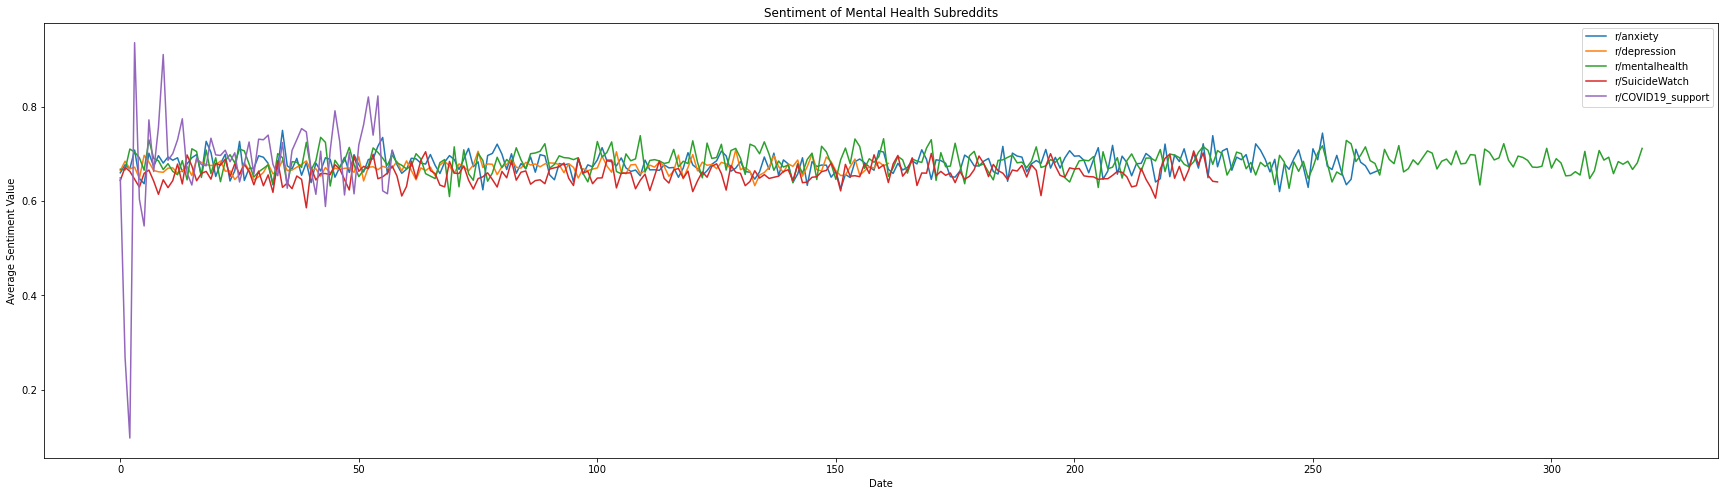

In [368]:
plt.figure(1,figsize=(30,8))

#Anxiety
anxiety_x = range(len(anxiety_dict))
anxiety_y = anxiety_dict.values()

plt.plot(anxiety_x,anxiety_y)

#Depression
depression_x = range(len(depression_dict))
depression_y = depression_dict.values()

plt.plot(depression_x,depression_y)

#MentalHealth
mentalhealth_x = range(len(mentalhealth_dict)) #not the right time period
mentalhealth_y = mentalhealth_dict.values()

plt.plot(mentalhealth_x,mentalhealth_y)

#SuicideWatch
suicidewatch_x = range(len(suicidewatch_dict)) #not the right time period
suicidewatch_y = suicidewatch_dict.values()

plt.plot(suicidewatch_x,suicidewatch_y)

#COVID19_support
COVID19_support_x = range(len(COVID19_support_dict)) #not the right time period
COVID19_support_y = COVID19_support_dict.values()

plt.plot(COVID19_support_x ,COVID19_support_y)

plt.title('Sentiment of Mental Health Subreddits')
plt.xlabel('Date')
plt.ylabel('Average Sentiment Value')

plt.legend(['r/anxiety', 'r/depression', 'r/mentalhealth', 'r/SuicideWatch', 'r/COVID19_support'])

plt.show()